Question 4

In [306]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import random
from scipy import linalg

# Import images
img1 = cv.imread('graf/img1.ppm')   
img5 = cv.imread('graf/img5.ppm')

Defining the functions to be used

In [313]:
def sift_match(im1, im2):
    '''used to sift match two images. We can adjust the good match percentage required to our liking'''

    GOOD_MATCH_PERCENT = 0.8

    # Detect sift features
    sift = cv.SIFT_create(nOctaveLayers = 3, contrastThreshold = 0.1, edgeThreshold = 25, sigma = 1)
    keypoint_1, descriptors_1 = sift.detectAndCompute(im1,None)
    keypoint_2, descriptors_2 = sift.detectAndCompute(im2,None)

    # Match features.
    matcher = cv.BFMatcher()
    matches = matcher.knnMatch(descriptors_1, descriptors_2, k = 2) 

    # Filter good matches using ratio test in Lowe's paper
    good_matches, points1, points2 = [], [], []

    for a,b in matches:
        if a.distance < GOOD_MATCH_PERCENT*b.distance:
            good_matches.append(a)
            points1.append(keypoint_1[a.queryIdx].pt)
            points2.append(keypoint_2[a.trainIdx].pt)

    good_matches, points1, points2 = np.array(good_matches), np.array(points1), np.array(points2)

    # Plot the matching
    fig, ax = plt.subplots(figsize = (15,15))
    ax.axis('off')
    matched_img = cv.drawMatches(im1, keypoint_1, im2, keypoint_2, good_matches, im2, flags = 2)
    plt.imshow(cv.cvtColor(matched_img,cv.COLOR_BGR2RGB))
    plt.show()



    return points1, points2


In [314]:
def homography(pts1, pts2):
    '''determining the homography between the two images'''
    A = []
    for i in range(len(pts1)):
        x1, y1, x2, y2 = pts1[i][0], pts1[i][1], pts2[i][0], pts2[i][1]
        A.append([-x1, -y1, -1, 0, 0, 0, x2*x1, x2*y1, x2])
        A.append([0, 0, 0, -x1, -y1, -1, y2*x1, y2*y1, y2])

    A = np.matrix(A)
    U, S, V = np.linalg.svd(A)
    H = np.reshape(V[-1], (3, 3))
    H = (1/H.item(8))*H
    return H

In [316]:
def dist(P1, P2, H):
    '''determing the distance between two points belonging to the two images'''
    p1 = np.transpose(np.matrix([P1[0], P1[1], 1]))
    estimatep2 = np.dot(H, p1)
    estimatep2 = (1/estimatep2.item(2))*estimatep2

    p2 = np.transpose(np.matrix([P2[0], P2[1], 1]))
    error = p2 - estimatep2
    return np.linalg.norm(error)

def RANSAC_homography(points1, points2):
    inlier_count, selected_inliers = 0, None
    
    points = np.hstack((points1, points2))
    num_iterations = int(np.log(1 - 0.95)/np.log(1 - (1 - 0.5)**4))
    threshold = 100
    
    
    for i in range(100):
        samples1 = []
        samples2 = []
        for k in range(4):
            idx = np.random.randint(0, len(points1))
            samples1.append(points1[idx])
            samples2.append(points2[idx])
        
        
        H = homography(samples1, samples2)
        
        inliers1, inliers2 = [], []
        
        for j in range(len(points1)):
            distance = dist(points1[j], points2[j], H)
            if distance < 5:
                inliers1.append(points1[j])
                inliers2.append(points2[j])
                                
        
        if len(inliers1) > threshold:
            max_inliers1 = inliers1
            max_inliers2 = inliers2
            H = homography(max_inliers1, max_inliers2)
       
    return H


Here we calculate the answers for the question.

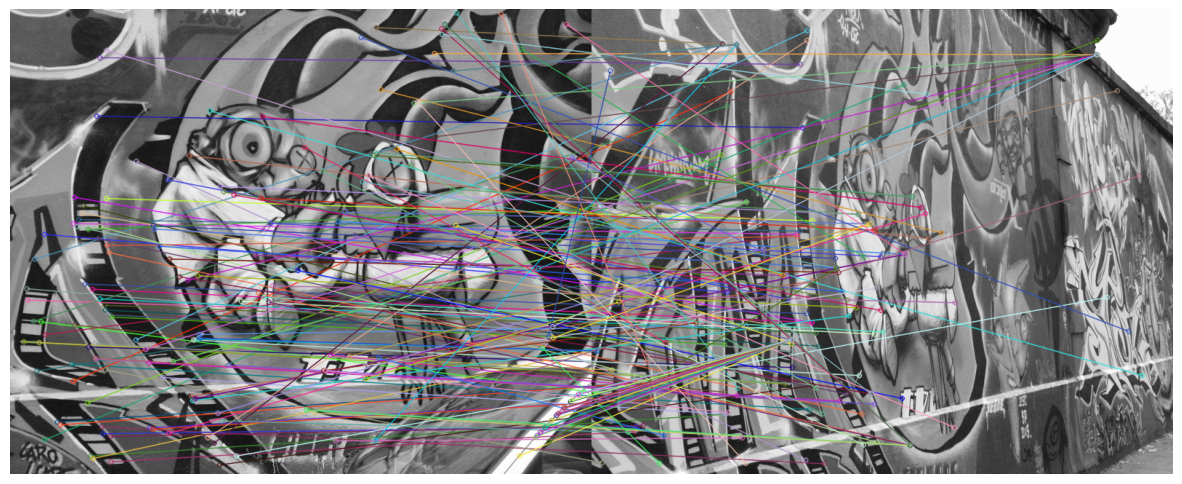

[[-3.88187650e-01 -1.25070136e+00  3.79707045e+02]
 [-5.46530342e-01 -1.73649073e+00  5.34220004e+02]
 [-1.00077993e-03 -3.35899949e-03  1.00000000e+00]]


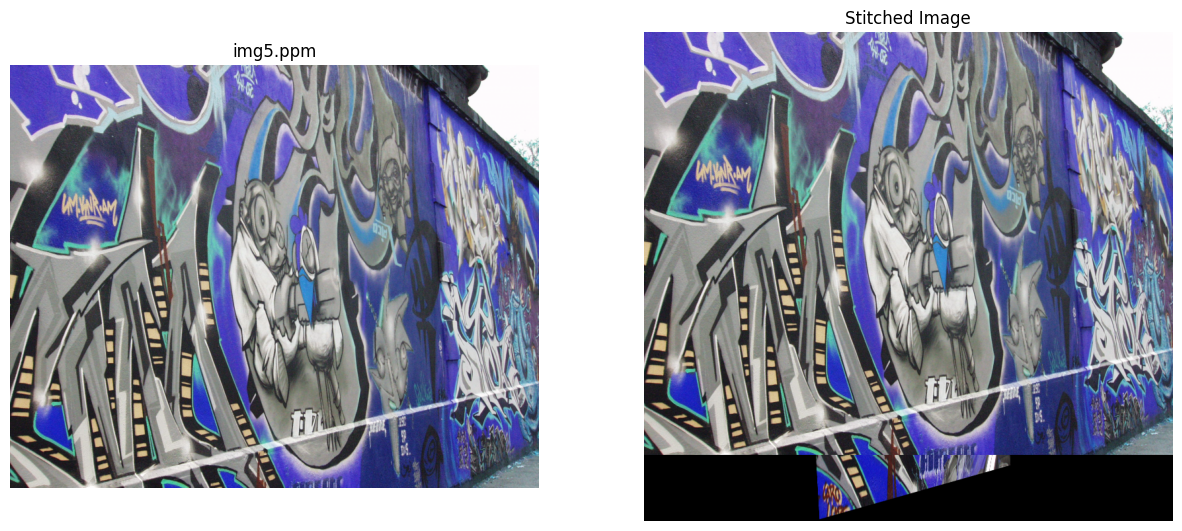

In [317]:
img1_gray = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
img5_gray = cv.cvtColor(img5, cv.COLOR_BGR2GRAY)

#Computing and matching SIFT features between the two images
points1, points2 = sift_match(img1_gray,img5_gray)

#Computing the homography using RANSAC
H = RANSAC_homography(points1, points2)
print(H)

#From H1to5p we obtain the value for H as,
H = np.array([[6.2544644e-01,   5.7759174e-02,   2.2201217e+02],
   [2.2240536e-01,   1.1652147e+00,  -2.5605611e+01],
   [4.9212545e-04,  -3.6542424e-05,  1.0000000e+00]])

#Finally we stich the two images img1 and img5
img_p = cv.warpPerspective(img1, H, (img5.shape[1], img5.shape[0]))

width = img1.shape[1] 
height = img1.shape[0] +100
img_p = cv.warpPerspective(img1, H, (width, height))
img_p[0:img5.shape[0], 0:img5.shape[1]] = img5

fig, ax = plt.subplots(1, 2, figsize=(15, 12))
ax[0].imshow(img5)
ax[0].set_title("img5.ppm")
ax[0].axis("off")
ax[1].imshow(img_p)
ax[1].set_title("Stitched Image")
ax[1].axis("off")

plt.show()